## Importing data

In [1]:
!wget https://cainvas-static.s3.amazonaws.com/media/user_data/Yuvnish17/data.zip
!mkdir training_data
!unzip data.zip -d /content/training_data

Streaming output truncated to the last 5000 lines.
  inflating: /content/training_data/data/dataset/4/EyvzNxyo.png  
  inflating: /content/training_data/data/dataset/4/FKiHJxiM.png  
  inflating: /content/training_data/data/dataset/4/fYZNZaxr.png  
  inflating: /content/training_data/data/dataset/4/gdzV7rOB.png  
  inflating: /content/training_data/data/dataset/4/h2Ky6HNV.png  
  inflating: /content/training_data/data/dataset/4/H9Z9P6GL.png  
  inflating: /content/training_data/data/dataset/4/hdpj5SYS.png  
  inflating: /content/training_data/data/dataset/4/IYih2BUF.png  
  inflating: /content/training_data/data/dataset/4/JIUtpRHr.png  
  inflating: /content/training_data/data/dataset/4/JWY8xpS7.png  
  inflating: /content/training_data/data/dataset/4/kcfSlc72.png  
  inflating: /content/training_data/data/dataset/4/KddA6Hj2.png  
  inflating: /content/training_data/data/dataset/4/KsrgnaRf.png  
  inflating: /content/training_data/data/dataset/4/LbZC4Bbn.png  
  inflating: /content/tra

## Importing necessary libraries

In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras import layers
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from keras.optimizers import Adam, SGD
from keras.regularizers import l2
from keras.utils import to_categorical
from tensorflow import keras
from keras._tf_keras.keras.preprocessing.image import ImageDataGenerator
import cv2
from sklearn.metrics import classification_report, confusion_matrix
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler, EarlyStopping, ModelCheckpoint
from sklearn.model_selection import StratifiedKFold
import os
from sklearn.preprocessing import StandardScaler

## Pre-processing data

In [132]:
labels=['0','1','2','3','4','5','6','7','8','9','add','div','mul','sub']

img_resize=32

def get_data(dir):
    data=[]
    for label in labels:
        path=os.path.join(dir, label)
        class_num=labels.index(label)
        for img in os.listdir(path):
            try:
                if img.endswith('jpg') or img.endswith('png'):
                    img_arr=cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
                    resized_arr=cv2.resize(img_arr,(img_resize, img_resize))
                    data.append([resized_arr,class_num])
            except Exception as e:
                print(e)
    return np.array(data,dtype='object')

train=get_data('/content/training_data/data/dataset')

## Data visualization

<Axes: xlabel='count'>

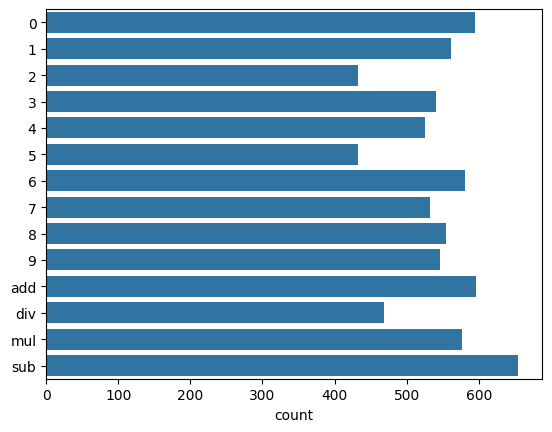

In [133]:
l=[]
for i in train:
  for label in range(14):
    if (i[1]==label):
        l.append (labels[label])


sns.countplot(l)

## Splitting data into training, testing, and validation subsections

In [168]:
x=[]
y=[]
x_temp=[]
x_train=[]
y_train=[]
x_val=[]
y_val=[]
x_test=[]
y_test=[]

for feat, label in train:
    x.append(feat)
    y.append(label)
x=np.array(x)
y=np.array(y)

skf = StratifiedKFold(n_splits=5, shuffle=True)
for train_index, temp_index in skf.split(x,y):
    x_train, x_temp = x[train_index], x[temp_index]
    y_train, y_temp = y[train_index], y[temp_index]

skf2=StratifiedKFold(n_splits=2)
for test_index, val_index in skf2.split(x_temp,y_temp):
    x_test, x_val = x_temp[test_index], x_temp[val_index]
    y_test, y_val = y_temp[test_index], y_temp[val_index]
x_train=np.array(x_train)/255
x_test=np.array(x_test)/255
x_vel=np.array(x_val)/255
y_train=to_categorical(y_train)
y_test=to_categorical(y_test)
y_val=to_categorical(y_val)
x_train=np.expand_dims(x_train, axis=-1)
y_train=np.array(y_train)
x_val=np.expand_dims(x_val, axis=-1)
y_val=np.array(y_val)
x_test=np.expand_dims(x_test, axis=-1)
y_test=np.array(y_test)

print(x_train.shape)

(6080, 32, 32, 1)


## Building and running model

In [169]:
model=Sequential()

model.add(Conv2D(32,(3,3),strides=1,padding='same',activation='relu',input_shape=(32,32,1)))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2),strides=2,padding='same'))

model.add(Conv2D(128,(3,3),strides=1,padding='same',activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2),strides=2,padding='same'))

model.add(Flatten())
model.add(Dense(units=1024,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=14,activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=0.0001,),loss='binary_crossentropy',metrics=['accuracy'])

model.summary()


learning_rate_reduction=ReduceLROnPlateau(monitor='val_accuracy',patience=2,verbose=1,factor=0.3,min_lr=0.00001)
history=model.fit(x_train,y_train,batch_size=32,epochs=32,validation_data=(x_val,y_val),callbacks=(learning_rate_reduction))
model.evaluate(x_test,y_test)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_48"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_96 (Conv2D)              │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_133 (Dropout)           │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_96          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_96 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_97 (Conv2D)              │ (None, 16, 16, 128)    │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_134 (Dropout)           │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_97          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_97 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_48 (Flatten)            │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_97 (Dense)                │ (None, 1024)           │     8,389,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_135 (Dropout)           │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_98 (Dense)                │ (None, 14)             │        14,350 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,441,934 (32.20 MB)

 Trainable params: 8,441,614 (32.20 MB)

 Non-trainable params: 320 (1.25 KB)

Epoch 1/32
190/190 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.3047 - loss: 0.8413 - val_accuracy: 0.0934 - val_loss: 10.1789 - learning_rate: 1.0000e-04
Epoch 2/32
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6163 - loss: 0.5389 - val_accuracy: 0.1513 - val_loss: 14.4682 - learning_rate: 1.0000e-04
Epoch 3/32
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7037 - loss: 0.4156 - val_accuracy: 0.3329 - val_loss: 17.4428 - learning_rate: 1.0000e-04
Epoch 4/32
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7724 - loss: 0.3273 - val_accuracy: 0.4868 - val_loss: 10.7945 - learning_rate: 1.0000e-04
Epoch 5/32
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8427 - loss: 0.2523 - val_accuracy: 0.5539 - val_loss: 9.7971 - learning_rate: 1.0000e-04
Epoch 6/32
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8856 - loss: 0.1982 - val_accuracy: 0.6368 - val_loss: 7.5555 - learning_rate: 1.0000e-04
Epoch 7/32
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accur

[0.06255917251110077, 0.9407894611358643]

## Testing model accuracy

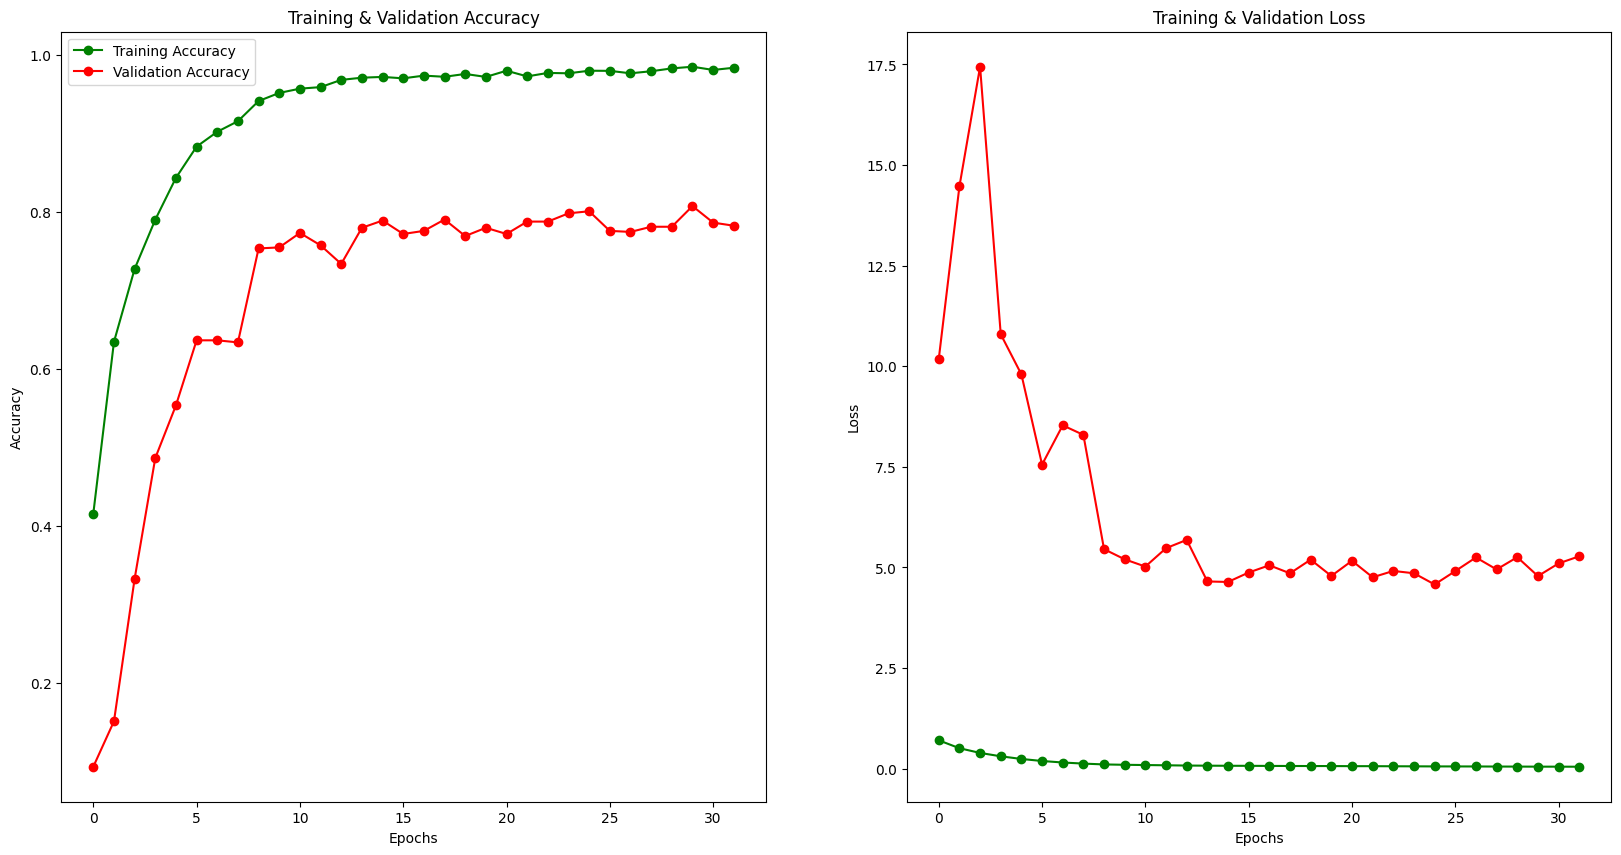

In [170]:
epochs=[i for i in range(32)]
fig, ax = plt.subplots(1,2)
train_acc=history.history['accuracy']
train_loss=history.history['loss']
val_acc=history.history['val_accuracy']
val_loss=history.history['val_loss']

fig.set_size_inches(20,10)
ax[0].plot(epochs, train_acc,'g-o',label='Training Accuracy')
ax[0].plot(epochs,val_acc,'r-o',label='Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

ax[1].plot(epochs, train_loss,'g-o', label='Training Loss')
ax[1].plot(epochs, val_loss,'r-o',label='Validation Loss')
ax[1].set_title('Training & Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')

plt.show()

In [171]:
predictions=(model.predict(x_test)>0.5).astype('int32')
print(classification_report(y_test,predictions, target_names=['0','1','2','3','4','5','6','7','8','9','add','div','mul','sub']))
trainpredictions=(model.predict(x_train)>0.5).astype('int32')
print(classification_report(y_train,trainpredictions, target_names=['0','1','2','3','4','5','6','7','8','9','add','div','mul','sub']))
valpredictions=(model.predict(x_val)>0.5).astype('int32')
print(classification_report(y_val,valpredictions, target_names=['0','1','2','3','4','5','6','7','8','9','add','div','mul','sub']))

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
              precision    recall  f1-score   support

           0       0.93      0.87      0.90        60
           1       0.98      0.91      0.94        56
           2       0.97      0.84      0.90        43
           3       1.00      0.89      0.94        54
           4       0.92      0.91      0.91        53
           5       1.00      0.81      0.90        43
           6       0.96      0.79      0.87        58
           7       0.98      0.92      0.95        53
           8       0.76      0.91      0.83        56
           9       0.94      0.93      0.93        54
         add       1.00      0.92      0.96        60
         div       1.00      1.00      1.00        47
         mul       0.97      0.98      0.97        58
         sub       1.00      0.97      0.98        65

   micro avg       0.95      0.91      0.93       760
   macro avg       0.96      0.90      0.93       760
weighted avg       0.96      0.91      0

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       476
           1       1.00      0.98      0.99       450
           2       1.00      0.98      0.99       346
           3       1.00      0.97      0.99       433
           4       1.00      0.97      0.98       421
           5       1.00      0.95      0.98       346
           6       1.00      0.98      0.99       465
           7       1.00      0.99      0.99       427
           8       0.93      1.00      0.96       443
           9       0.97      1.00      0.98       437
         add       1.00      0.99      1.00       476
         div       1.00      1.00      1.00       375
         mul       0.99      1.00      1.00       461
         sub       1.00      1.00      1.00       524

   micro avg       0.99      0.99      0.99      6080
   macro avg       0.99      0.99      0.99      6080
weighted avg       0.99      0.99      

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
              precision    recall  f1-score   support

           0       0.98      0.73      0.83        59
           1       1.00      0.14      0.25        56
           2       0.92      0.80      0.85        44
           3       1.00      0.74      0.85        54
           4       0.78      0.96      0.86        52
           5       0.97      0.84      0.90        44
           6       0.94      0.79      0.86        58
           7       0.97      0.58      0.73        53
           8       0.96      0.95      0.95        55
           9       0.94      0.62      0.75        55
         add       1.00      0.97      0.98        60
         div       1.00      0.91      0.95        46
         mul       1.00      0.71      0.83        58
         sub       1.00      0.18      0.31        66

   micro avg       0.95      0.70      0.80       760
   macro avg       0.96      0.71      0.78       760
weighted avg       0.96      0.70      0

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Testing model using uploaded images

In [172]:
!rm -rf Amberg-Final-project/
!git clone https://github.com/klamberg/Amberg-Final-project.git
#!wget https://github.com/klamberg/Amberg-Final-project/tree/fc497828fabd0261946f4f73e822525cc8ede8e9/uploaded_images

Cloning into 'Amberg-Final-project'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 32 (delta 2), reused 3 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (32/32), 1.11 MiB | 15.12 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [173]:
img_resize=32
def uploaded_images(path):
    data=[]
    for img in os.listdir(path):
        try:
            if img.endswith('jpg') or img.endswith('png'):
                img_arr=cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
                resized_arr=cv2.resize(img_arr,(img_resize, img_resize))
                data.append(resized_arr)
        except Exception as e:
            print(e)
    return np.array(data)
images=uploaded_images('/content/Amberg-Final-project/uploaded_images')
x=[]
for feat in images:
  x.append(feat)
x=np.array(x)/255
x=np.expand_dims(x,axis=-1)



## Predict numbers in uploaded images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


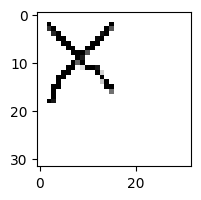

mul

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


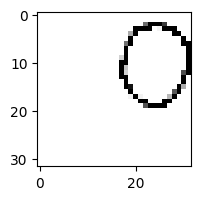

0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


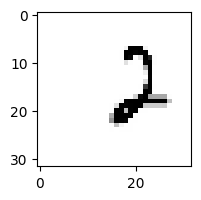

2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


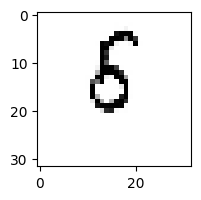

8

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


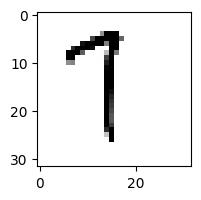

7

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


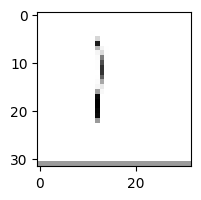

1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


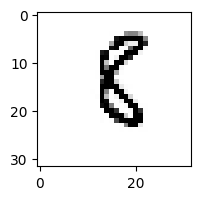

8

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


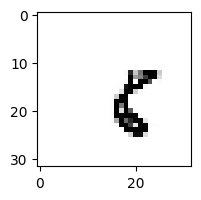

8



In [184]:
labels=['0','1','2','3','4','5','6','7','8','9','add','div','mul','sub']
for i in range(len(images)):
  prediction=model.predict(np.array([np.array(x[i])]))
  predict=np.argmax(prediction,axis=1)

  plt.figure(figsize=(2, 2))
  plt.imshow(images[i],cmap='gray')
  plt.show()
  print(labels[predict[0]])
  print()